# Vehicle Recall Predictions

# Required Code

This is the code required to load the datasets we need

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re
# Written by: Matt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

data_path = 'data'
fields_path = 'fields'

# Written by: David
# Read and parse a file containing column names for a dataset.
# Returns a list of strings (the column names).
def load_column_names(columns_file_name):
    file = open(columns_file_name)
    column_names = []
    readingFields = False
    for line in file:
        if readingFields:
            if re.match('^[0-9]', line):
                split_line = line.split()
                column_names.append(split_line[1])
        elif line.startswith('Field#'):
            readingFields = True
    file.close()
    return column_names
#}

# Written by: David
# Load a dataest by its abbreviated names (ex: RCL).
def load_data_file(name, encoding):
    
    # Read the column names from a separate file.
    fields_file_name = fields_path + '/' + name + '.txt';
    names = load_column_names(fields_file_name)
    
    # Read the data from a CSV file.
    data_file_name = 'FLAT_' + name + '.txt';
    df = pd.read_csv(data_path + '/' + data_file_name,
                     delimiter='\t', header=None, encoding=encoding, names=names)
    
    return df
#}

print("done")

done


# Data cleaning for prediction

## Load the Complaints dataset

In [22]:
# Load the complaints dataset.
# Only use a subset of the data (because there is a lot of it)
cmpl_train_df = load_data_file('CMPL', encoding='iso-8859-1').tail(1000)

C:\Users\whomp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (15,22,26,30,32,33,34,35,36,38,39,40,41,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Filter and clean the Complaints dataset

In [28]:
# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols

# Written by: David
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
clean_train_df = cmpl_train_df[(cmpl_train_df['MAKETXT'] != 'UNKNOWN') &
                   (cmpl_train_df['MODELTXT'] != 'UNKNOWN') &
                   (cmpl_train_df['YEARTXT'] > 1900) &
                   (cmpl_train_df['YEARTXT'] < 2020) &
                   (cmpl_train_df['PROD_TYPE'] == 'V')][all_cols + ['CMPLID']].copy()

# Written by: David
# Convert certain columns to a numerical data type.
clean_train_df['NUM_CYLS'] = pd.to_numeric(clean_train_df['NUM_CYLS'], errors='coerce')
clean_train_df['DATEA'] = pd.to_numeric(clean_train_df['DATEA'], errors='coerce')

# Written by: David
# Replace particular "bogus" values with NaN, which get filled later.
clean_train_df['INJURED'] = clean_train_df['INJURED'].replace(99, np.nan).fillna(0)
clean_train_df['DEATHS'] = clean_train_df['DEATHS'].replace(99, np.nan).fillna(0)

# Written by: David
# Clamp the values for specific numerical columns.
clean_train_df['NUM_CYLS'] = clean_train_df['NUM_CYLS'].clip(4, 8)
clean_train_df['MILES'] = clean_train_df['MILES'].clip(0, 300000)
clean_train_df['OCCURENCES'] = clean_train_df['OCCURENCES'].clip(1, 10)
clean_train_df['VEH_SPEED'] = clean_train_df['VEH_SPEED'].clip(0, 100)

# Written by: Christian
# Clean values in component descriptions
# Custom split function to pass to apply
def split(comp):
    if type(comp) != str:
        return ''
    return comp.split(':')[0]

# Written by: Christian
# Generalize the names of each component
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].apply(split)

# Written by: Christian
# Fix differences between component names in complaints and recalls
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('FUEL/PROPULSION SYSTEM','FUEL SYSTEM').replace('AIR BAG','AIR BAGS')
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('OTHER','').replace('UNKNOWN OR OTHER','')

# Written by: David
# Replace 'Y' and 'N' with 1 and 0 for boolean columns.
# Also convert them to numeric so we can average them.
# This will allow us to get a percentage of 'yes' for each vehicle type.
for column in bool_cols:
    clean_train_df[column] = clean_train_df[column].replace('Y', 1).replace('N', 0)
    clean_train_df[column] = pd.to_numeric(clean_train_df[column])

# Print out part of the resulting semi-clean data set
clean_train_df[all_cols].head(10)

,MAKETXT,MODELTXT,YEARTXT,COMPDESC,CRASH,FIRE,POLICE_RPT_YN,ORIG_OWNER_YN,ANTI_BRAKES_YN,CRUISE_CONT_YN,...,DEATHS,MILES,OCCURENCES,NUM_CYLS,VEH_SPEED,DATEA,DRIVE_TRAIN,FUEL_SYS,FUEL_TYPE,TRANS_TYPE
1364557,TOYOTA,COROLLA,2009.0,AIR BAGS,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364558,HYUNDAI,SANTA FE,2011.0,POWER TRAIN,0,0,0,0,0,0,...,0.0,96000.0,NaN,NaN,20.0,20170324,NaN,NaN,NaN,NaN
1364559,AUDI,A4,2014.0,ENGINE,0,0,0,0,0,0,...,0.0,62000.0,NaN,NaN,55.0,20170324,NaN,NaN,NaN,NaN
1364560,FORD,FOCUS,2015.0,STEERING,0,0,0,0,0,0,...,0.0,19039.0,NaN,NaN,60.0,20170324,NaN,NaN,NaN,NaN
1364561,JEEP,PATRIOT,2013.0,AIR BAGS,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364562,FORD,F-150,2016.0,POWER TRAIN,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364563,HYUNDAI,SONATA,2011.0,STEERING,0,0,0,0,0,0,...,0.0,36000.0,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364564,VOLVO,XC70,2012.0,,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364565,FORD,FUSION,2008.0,AIR BAGS,0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,NaN,20170324,NaN,NaN,NaN,NaN
1364566,JEEP,WRANGLER,2012.0,ELECTRICAL SYSTEM,0,0,0,0,0,0,...,0.0,92000.0,NaN,NaN,60.0,20170324,NaN,NaN,NaN,NaN


## Group complaints by make/model/year and perform aggregate functions on the column values

Warning: this step takes a few minutes to perform all the aggregate functions

In [29]:
# Written by: David
# Aggregate function which Returns the mode of a series.
# If there is no valid mode, but there are any amount of
# non-null values, then the first non-null value is returned.
# Otherwise, if all values are NaN, then NaN is returned
def aggMode(x):
    column_mode = x.mode()
    
    # If there is a valid mode, return it
    if column_mode.count() > 0:
        return column_mode[0]
   
    # if there are any non-null values, return one of them
    first_valid = x.first_valid_index()
    if first_valid != None:
        return x[first_valid]
    
    return np.nan
#}

In [30]:
# Written by: David
# Group the dataset by the key columns (make/model/year/component)
grouped = clean_train_df.groupby(key_cols)

# Written by: David
# Perform aggregate functions on the columns for each vehicle type.
# Aggregate with the mode for categorical columns
# Aggregate with the mean for numerical columns
grouped_df = pd.DataFrame()
for col in cat_cols:
    grouped_df[col] = grouped[col].agg(aggMode)
for col in numer_cols:
    grouped_df[col] = grouped[col].mean()

# Written by: David
# Add in a column for the number of complaints for each vehicle-component.
grouped_df['COMPLAINTS'] = grouped.size()
numer_cols.append('COMPLAINTS');
all_cols.append('COMPLAINTS');

#print('done')
grouped_df.head(10)

DRIVE_TRAIN  FUEL_SYS  \
MAKETXT MODELTXT YEARTXT COMPDESC                                      
ACURA   MDX      2002.0  POWER TRAIN                   NaN       NaN   
                         VEHICLE SPEED CONTROL         NaN       NaN   
                 2004.0  AIR BAGS                      NaN       NaN   
                 2014.0  VEHICLE SPEED CONTROL         NaN       NaN   
        TL       2002.0  POWER TRAIN                   NaN       NaN   
                 2003.0  POWER TRAIN                   NaN       NaN   
AUDI    A3       2006.0  AIR BAGS                      NaN       NaN   
        A4       2006.0  AIR BAGS                      NaN       NaN   
                 2007.0  AIR BAGS                      NaN       NaN   
                 2014.0  ENGINE                        NaN       NaN   

                                               FUEL_TYPE  TRANS_TYPE  CRASH  \
MAKETXT MODELTXT YEARTXT COMPDESC                                             
ACURA   MDX      2002.0  POWER TRAIN                 NaN         NaN    0.0   
                         VEHICLE SPEED CONTROL       NaN         NaN    0.0   
                 2004.0  AIR BAGS                    NaN         NaN    0.0   
                 2014.0  VEHICLE SPEED CONTROL       NaN         NaN    0.0   
        TL       2002.0  POWER TRAIN                 NaN         NaN    0.0   
                 2003.0  POWER TRAIN                 NaN         NaN    0.0   
AUDI    A3       2006.0  AIR BAGS                    NaN         NaN    0.0   
        A4       2006.0  AIR BAGS                    NaN         NaN    0.0   
                 2007.0  AIR BAGS                    NaN         NaN    0.0   
                 2014.0  ENGINE                      NaN         NaN    0.0   

                                                FIRE  POLICE_RPT_YN  \
MAKETXT MODELTXT YEARTXT COMPDESC                                     
ACURA   MDX      2002.0  POWER TRAIN             0.0            0.0   
                         VEHICLE SPEED CONTROL   0.0            0.0   
                 2004.0  AIR BAGS                0.0            0.0   
                 2014.0  VEHICLE SPEED CONTROL   0.0            0.0   
        TL       2002.0  POWER TRAIN             0.0            0.0   
                 2003.0  POWER TRAIN             0.0            0.0   
AUDI    A3       2006.0  AIR BAGS                0.0            0.0   
        A4       2006.0  AIR BAGS                0.0            0.0   
                 2007.0  AIR BAGS                0.0            0.0   
                 2014.0  ENGINE                  0.0            0.0   

                                                ORIG_OWNER_YN  ANTI_BRAKES_YN  \
MAKETXT MODELTXT YEARTXT COMPDESC                                               
ACURA   MDX      2002.0  POWER TRAIN                        0               0   
                         VEHICLE SPEED CONTROL              0               0   
                 2004.0  AIR BAGS                           0               0   
                 2014.0  VEHICLE SPEED CONTROL              0               0   
        TL       2002.0  POWER TRAIN                        0               0   
                 2003.0  POWER TRAIN                        0               0   
AUDI    A3       2006.0  AIR BAGS                           0               0   
        A4       2006.0  AIR BAGS                           0               0   
                 2007.0  AIR BAGS                           0               0   
                 2014.0  ENGINE                             0               0   

                                                CRUISE_CONT_YN  MEDICAL_ATTN  \
MAKETXT MODELTXT YEARTXT COMPDESC                                              
ACURA   MDX      2002.0  POWER TRAIN                         0           0.0   
                         VEHICLE SPEED CONTROL               0           0.0   
                 2004.0  AIR BAGS                            0           0.0   
       

## Replace missing values with the mean or mode for that column over the entire dataset

In [6]:
# Written by: David

# Replace NaN with mode for categorical columns
for col in cat_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mode()[0])

# Replace NaN with mean for numerical columns
for col in numer_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mean())

print('done')

done


In [7]:
# Print out the grouped dataset.
grouped_df

DRIVE_TRAIN  \
MAKETXT         MODELTXT          YEARTXT COMPDESC                                   
.               MALIBU            1998.0  EXTERIOR LIGHTING                    FWD   
3 TON UTILITY   3EC14             2003.0  STRUCTURE                            FWD   
                                          TRAILER HITCHES                      FWD   
4 TON UTILITY   4EC16W            2001.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          STEERING                             FWD   
                                          VEHICLE SPEED CONTROL                FWD   
                                  2002.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          STRUCTURE                            FWD   
4-STAR          HORSE TRAILER     2006.0  ELECTRICAL SYSTEM                    FWD   
                                          ENGINE                               FWD   
                                          EXTERIOR LIGHTING                    FWD   
                                  2008.0  POWER TRAIN                          FWD   
                                  2012.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          ENGINE                               FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
4-STAR TRAILER  CARGO BUMPER PULL 2000.0  POWER TRAIN                          FWD   
                                          SERVICE BRAKES                       FWD   
                                  2005.0  SERVICE BRAKES                       FWD   
                CARGO GOOSENECK   2005.0  STEERING                             FWD   
                                          SUSPENSION                           FWD   
                HORSE BUMPER PULL 2008.0                                       FWD   
                HORSE GOOSENECK   2001.0  WHEELS                               FWD   
                                  2009.0  SERVICE BRAKES                       FWD   
                POLO GOOSENECK    2006.0  ELECTRICAL SYSTEM                    FWD   
                                  2007.0  ELECTRICAL SYSTEM                    FWD   
                STOCK BUMPER PULL 2003.0  SERVICE BRAKES                       FWD   
                                  2010.0  AIR BAGS                             FWD   
4-STAR TRAILERS HORSE TRAILER     2003.0  STRUCTURE                            FWD   
                                  2004.0  SUSPENSION                           FWD   
                                          TIRES                                FWD   
...                                                                            ...   
YAMAHA          ZUMA              2009.0  ELECTRICAL SYSTEM                    FWD   
                                          FUEL SYSTEM                          FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
                                  2011.0  ELECTRICAL SYSTEM                    FWD   
                                          ENGINE                               FWD   
                                          FUEL SYSTEM                          FWD   
YAMAHA V STAR   1100 SILVERADO    2006.0  ELECTRICAL SYSTEM                    RWD   
                                          POWER TRAIN                          RWD   
YOKOHAMA        YOKOHAMA          1990.0  TIRES                                FWD   
                                  1994.0  TIRES                                FWD   
ZAP             XEBRA             2008.0                                       FWD   
                                          ELECTRICAL SYSTEM                    FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
                                          POWER TRAIN                          FWD   
                             

## Check which vehicle types exist in the Recalls dataset

Warning: This is the longest step and it will take several minutes

In [8]:
# Load the recall dataset
rcl_df = load_data_file('RCL', encoding='latin1');

C:\Users\whomp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
# Written by: Christian
# Rename the component field in recalls so it matches complaints
recalled_set = rcl_df.rename(columns = {'COMPNAME':'COMPDESC'})

# Written by: David
# Create the set of vehicle types from the recalled dataset.
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
#--Christian - switched to all columns, doesn't take much longer and makes next part easier
recalled_set = recalled_set[(rcl_df['MAKETXT'] != 'UNKNOWN') &
                      (rcl_df['MODELTXT'] != 'UNKNOWN') &
                      (rcl_df['YEARTXT'] > 1900) &
                      (rcl_df['YEARTXT'] < 2020) &
                      (rcl_df['RCLTYPECD'] == 'V')][recalled_set.columns.values].copy()

# Written by: Christian
# Generalize the names of each component
recalled_set['COMPDESC'] = recalled_set['COMPDESC'].apply(split)

# Convert Date to a numeric value
recalled_set['RCDATE'] = pd.to_numeric(recalled_set['RCDATE'], errors='coerce')


# Written by: David
# Make the recalled set only have unique vehicle types,
# mostly for efficiency in the next step.
recalled_set = recalled_set[key_cols + ["RCDATE"]].groupby(key_cols)
print("done")

done


In [10]:
# Written by: Matt/Christian
# Now create the columns in the complaints set which says
# whether a vehicle type is in the recalled sets.
# --Christian - switched so it only counts as recalled if the recall happened after the complaint
# added whether or not the car was recalled within a period of time
# switched to a mix of integer and label indexing for accuracy purposes
grouped_df['RECALLED'] = False
grouped_df['RECALLED_1YR'] = False
grouped_df['RECALLED_3YR'] = False
grouped_df['RECALLED_5YR'] = False
for int_index in range(len(grouped_df)):
    #get the old label based index aka key_cols
    index = grouped_df.iloc[int_index].name
    #key exists in recalls
    if(index in recalled_set.indices):
        #list of all recall dates YYYYMMDD format
        recalled_dates = recalled_set.get_group(index)["RCDATE"].get_values()
        #date of current recall
        comp_date = grouped_df.iloc[int_index]["DATEA"]
        for rcl_date in recalled_dates:
            if comp_date < rcl_date:
                grouped_df.ix[int_index,'RECALLED'] = True
                if comp_date + 50000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_5YR"] = True
                if comp_date + 30000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_3YR"] = True
                if comp_date + 10000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_1YR"] = True
print(grouped_df['RECALLED'].value_counts())
print(grouped_df['RECALLED_5YR'].value_counts())
print(grouped_df['RECALLED_3YR'].value_counts())
print(grouped_df['RECALLED_1YR'].value_counts())


False    155189
True       3996
Name: RECALLED, dtype: int64
False    155499
True       3686
Name: RECALLED_5YR, dtype: int64
False    155919
True       3266
Name: RECALLED_3YR, dtype: int64
False    157202
True       1983
Name: RECALLED_1YR, dtype: int64


# Random Decision Forest Prediction

## Prepare data for training and validation

In [23]:
# Load the grouped data from file
grouped_df = pd.read_csv('fullData.txt', index_col=[0,1,2,3])

# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols
numer_cols.append('COMPLAINTS')
all_cols.append('COMPLAINTS')

print('done')

done


In [24]:
# Function to grab 'n' number of random samples from a dataframe 'x'
import random
def some(x, n):
    return x.ix[random.sample(set(x.index), n)]

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData = some(recalledSamples, numSamples)
fullData = fullData.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_5yr = some(recalledSamples, numSamples)
fullData_5yr = fullData_5yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_3yr = some(recalledSamples, numSamples)
fullData_3yr = fullData_3yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_1yr = some(recalledSamples, numSamples)
fullData_1yr = fullData_1yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')
fullData.head(10)

Gathered 3996 recalled components and 3996 non-recalled components
Gathered 3686 recalled components and 3686 non-recalled components
Gathered 3266 recalled components and 3266 non-recalled components
Gathered 1983 recalled components and 1983 non-recalled components


DRIVE_TRAIN  \
MAKETXT    MODELTXT         YEARTXT COMPDESC                                
TESLA      MODEL X          2016.0  SEATS                             FWD   
FLEETWOOD  PROWLER          2001.0  EQUIPMENT                         FWD   
REXHALL    AERBUS           1999.0  POWER TRAIN                       FWD   
FORD       F-350            1994.0  VEHICLE SPEED CONTROL             4WD   
TOYOTA     HIGHLANDER       2006.0  SERVICE BRAKES, HYDRAULIC           U   
CHRYSLER   TOWN AND COUNTRY 2015.0  VISIBILITY                        FWD   
           300M             1999.0  POWER TRAIN                       FWD   
OLDSMOBILE INTRIGUE         1998.0  ELECTRICAL SYSTEM                 FWD   
JEEP       COMMANDER        2008.0  POWER TRAIN                       4WD   
CHEVROLET  MONTE CARLO      2000.0  ENGINE AND ENGINE COOLING         FWD   

                                                              FUEL_SYS  \
MAKETXT    MODELTXT         YEARTXT COMPDESC                             
TESLA      MODEL X          2016.0  SEATS                           FI   
FLEETWOOD  PROWLER          2001.0  EQUIPMENT                       FI   
REXHALL    AERBUS           1999.0  POWER TRAIN                      F   
FORD       F-350            1994.0  VEHICLE SPEED CONTROL            F   
TOYOTA     HIGHLANDER       2006.0  SERVICE BRAKES, HYDRAULIC       FI   
CHRYSLER   TOWN AND COUNTRY 2015.0  VISIBILITY                      FI   
           300M             1999.0  POWER TRAIN                      F   
OLDSMOBILE INTRIGUE         1998.0  ELECTRICAL SYSTEM               FI   
JEEP       COMMANDER        2008.0  POWER TRAIN                     FI   
CHEVROLET  MONTE CARLO      2000.0  ENGINE AND ENGINE COOLING       FI   

                                                              FUEL_TYPE  \
MAKETXT    MODELTXT         YEARTXT COMPDESC                              
TESLA      MODEL X          2016.0  SEATS                            GS   
FLEETWOOD  PROWLER          2001.0  EQUIPMENT                        GS   
REXHALL    AERBUS           1999.0  POWER TRAIN                      GS   
FORD       F-350            1994.0  VEHICLE SPEED CONTROL            DS   
TOYOTA     HIGHLANDER       2006.0  SERVICE BRAKES, HYDRAULIC        HE   
CHRYSLER   TOWN AND COUNTRY 2015.0  VISIBILITY                       GS   
           300M             1999.0  POWER TRAIN                      GS   
OLDSMOBILE INTRIGUE         1998.0  ELECTRICAL SYSTEM                GS   
JEEP       COMMANDER        2008.0  POWER TRAIN                      GS   
CHEVROLET  MONTE CARLO      2000.0  ENGINE AND ENGINE COOLING        GS   

                                                              TRANS_TYPE  \
MAKETXT    MODELTXT         YEARTXT COMPDESC                               
TESLA      MODEL X          2016.0  SEATS                           AUTO   
FLEETWOOD  PROWLER          2001.0  EQUIPMENT                       AUTO   
REXHALL    AERBUS           1999.0  POWER TRAIN                     AUTO   
FORD       F-350            1994.0  VEHICLE SPEED CONTROL           AUTO   
TOYOTA     HIGHLANDER       2006.0  SERVICE BRAKES, HYDRAULIC       AUTO   
CHRYSLER   TOWN AND COUNTRY 2015.0  VISIBILITY                      AUTO   
           300M             1999.0  POWER TRAIN                     AUTO   
OLDSMOBILE INTRIGUE         1998.0  ELECTRICAL SYSTEM               AUTO   
JEEP       COMMANDER        2008.0  POWER TRAIN                     AUTO   
CHEVROLET  MONTE CARLO      2000.0  ENGINE AND ENGINE COOLING       AUTO   

                                                                  CRASH  \
MAKETXT    MODELTXT         YEARTXT COMPDESC                              
TESLA      MODEL X          2016.0  SEATS                      0.000000   
FLEETWOOD  PROWLER          2001.0  EQUIPMENT                  0.000000   
REXHALL    AERBUS           1999.0  POWER TRAIN                0.000000   
FORD       F-350            1994.0  VEHICLE SPEED CONTROL  

In [25]:
# Written by: David
# Drop columns that have missing values. Our previous
# steps would have filled all missing values UNLESS
# the column is entirely filled with null. Therefore,
# just drop columns that are null, they don't tell us anything.
for col in cat_cols + numer_cols:
    if fullData[col].isnull().any():
        print('Dropping column ', col)
        fullData.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_5yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_5yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_3yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_3yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_1yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_1yr.drop(col, axis=1,inplace=True)

# Written by: Matt
# Create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))
    fullData_5yr[var] = number.fit_transform(fullData_5yr[var].astype('str'))
    fullData_3yr[var] = number.fit_transform(fullData_3yr[var].astype('str'))
    fullData_1yr[var] = number.fit_transform(fullData_1yr[var].astype('str'))

# Written by: Matt
# Target variable is also a categorical so convert it
fullData['RECALLED'] = number.fit_transform(fullData['RECALLED'].astype('str'))
fullData_5yr['RECALLED_5YR'] = number.fit_transform(fullData_5yr['RECALLED_5YR'].astype('str'))
fullData_3yr['RECALLED_3YR'] = number.fit_transform(fullData_3yr['RECALLED_3YR'].astype('str'))
fullData_1yr['RECALLED_1YR'] = number.fit_transform(fullData_1yr['RECALLED_1YR'].astype('str'))

# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData['is_train'] = np.random.uniform(0, 1, len(fullData)) <= .75
Train, Validate = fullData[fullData['is_train']==True], fullData[fullData['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])
print()

Training set size = 5955
Validation set size = 2037



In [26]:
Train.columns

Index(['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE', 'CRASH', 'FIRE',
       'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN',
       'MEDICAL_ATTN', 'VEHICLES_TOWED_YN', 'INJURED', 'DEATHS', 'MILES',
       'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED', 'DATEA', 'COMPLAINTS',
       'RECALLED', 'RECALLED_1YR', 'RECALLED_3YR', 'RECALLED_5YR', 'is_train'],
      dtype='object')

# Run Testing for Recalled target

In [27]:
# Written by: Matt
# Get a list of the defining features.
features = list(set(list(fullData.columns)) - set(['RECALLED','RECALLED_5YR','RECALLED_1YR','RECALLED_3YR','is_train','DATEA']))

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED'].values

In [28]:
features

['FIRE',
 'POLICE_RPT_YN',
 'COMPLAINTS',
 'FUEL_TYPE',
 'MILES',
 'ORIG_OWNER_YN',
 'NUM_CYLS',
 'VEHICLES_TOWED_YN',
 'CRASH',
 'DEATHS',
 'TRANS_TYPE',
 'ANTI_BRAKES_YN',
 'DRIVE_TRAIN',
 'FUEL_SYS',
 'INJURED',
 'VEH_SPEED',
 'MEDICAL_ATTN',
 'CRUISE_CONT_YN',
 'OCCURENCES']

## Calculate and plot the ROC Curve

In [29]:
# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

Area under ROC curve = 0.745811804097


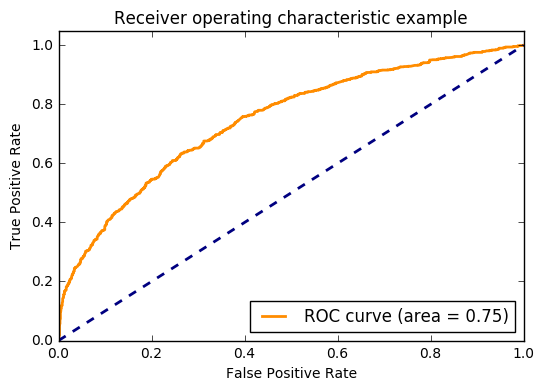

In [30]:
# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Calculate the Confusion Matrix

In [31]:
# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')


confusion matrix:
[[711 327]
 [324 675]]

711  non-recalled cars were predicted to be not recalled
327  non-recalled cars were predicted to be recalled
324  recalled cars were predicted to be not recalled
675  recalled cars were predicted to be recalled


## Calculate the Accuracy & Mean Squared Error

In [32]:
# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

accuracy = 0.680412371134
Mean squared error = 0.319587628866


# Run Testing for Recalled within five year target

Training set size = 5484
Validation set size = 1888
Area under ROC curve = 0.758772372833


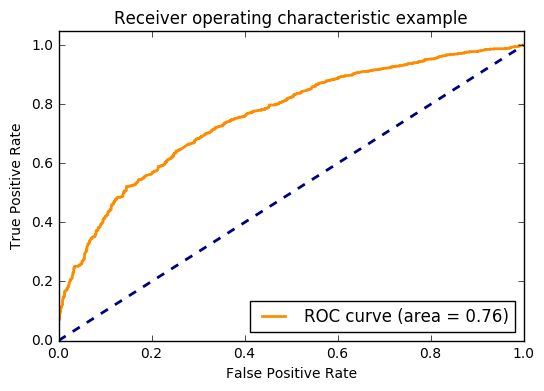

confusion matrix:
[[682 272]
 [311 623]]

682  non-recalled cars were predicted to be not recalled
272  non-recalled cars were predicted to be recalled
311  recalled cars were predicted to be not recalled
623  recalled cars were predicted to be recalled
accuracy = 0.691207627119
Mean squared error = 0.308792372881


In [33]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_5yr['is_train'] = np.random.uniform(0, 1, len(fullData_5yr)) <= .75
Train, Validate = fullData_5yr[fullData_5yr['is_train']==True], fullData_5yr[fullData_5yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_5YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_5YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for Recalled within three year target

In [34]:
features

['FIRE',
 'POLICE_RPT_YN',
 'COMPLAINTS',
 'FUEL_TYPE',
 'MILES',
 'ORIG_OWNER_YN',
 'NUM_CYLS',
 'VEHICLES_TOWED_YN',
 'CRASH',
 'DEATHS',
 'TRANS_TYPE',
 'ANTI_BRAKES_YN',
 'DRIVE_TRAIN',
 'FUEL_SYS',
 'INJURED',
 'VEH_SPEED',
 'MEDICAL_ATTN',
 'CRUISE_CONT_YN',
 'OCCURENCES']

Training set size = 4913
Validation set size = 1619
Area under ROC curve = 0.758449096331


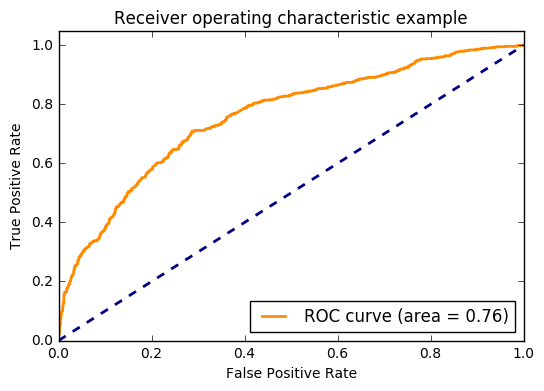

confusion matrix:
[[567 234]
 [239 579]]

567  non-recalled cars were predicted to be not recalled
234  non-recalled cars were predicted to be recalled
239  recalled cars were predicted to be not recalled
579  recalled cars were predicted to be recalled
accuracy = 0.707844348363
Mean squared error = 0.292155651637


In [35]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_3yr['is_train'] = np.random.uniform(0, 1, len(fullData_3yr)) <= .75
Train, Validate = fullData_3yr[fullData_3yr['is_train']==True], fullData_3yr[fullData_3yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_3YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_3YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for 1 year target

Training set size = 3009
Validation set size = 957
Area under ROC curve = 0.756657865286


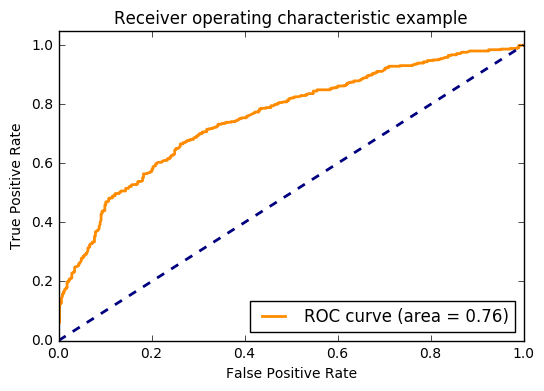

confusion matrix:
[[357 136]
 [150 314]]

357  non-recalled cars were predicted to be not recalled
136  non-recalled cars were predicted to be recalled
150  recalled cars were predicted to be not recalled
314  recalled cars were predicted to be recalled
accuracy = 0.701149425287
Mean squared error = 0.298850574713


In [36]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_1yr['is_train'] = np.random.uniform(0, 1, len(fullData_1yr)) <= .75
Train, Validate = fullData_1yr[fullData_1yr['is_train']==True], fullData_1yr[fullData_1yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_1YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_1YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

In [37]:
# Load the grouped data from file
grouped_df = pd.read_csv('fullData.txt', index_col=[0,1,2,3])
# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols
numer_cols.append('COMPLAINTS')
all_cols.append('COMPLAINTS')

grouped_df.head(10)

DRIVE_TRAIN  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                   
.             MALIBU        1998.0  EXTERIOR LIGHTING                    FWD   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                            FWD   
                                    TRAILER HITCHES                      FWD   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL         FWD   
                                    STEERING                             FWD   
                                    VEHICLE SPEED CONTROL                FWD   
                            2002.0  ELECTRONIC STABILITY CONTROL         FWD   
                                    STRUCTURE                            FWD   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                    FWD   
                                    ENGINE                               FWD   

                                                                 FUEL_SYS  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                
.             MALIBU        1998.0  EXTERIOR LIGHTING                  FI   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                          FI   
                                    TRAILER HITCHES                    FI   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL       FI   
                                    STEERING                           FI   
                                    VEHICLE SPEED CONTROL              FI   
                            2002.0  ELECTRONIC STABILITY CONTROL       FI   
                                    STRUCTURE                          FI   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                  FI   
                                    ENGINE                             FI   

                                                                 FUEL_TYPE  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                 
.             MALIBU        1998.0  EXTERIOR LIGHTING                   GS   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                           GS   
                                    TRAILER HITCHES                     GS   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL        GS   
                                    STEERING                            GS   
                                    VEHICLE SPEED CONTROL               GS   
                            2002.0  ELECTRONIC STABILITY CONTROL        GS   
                                    STRUCTURE                           GS   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                   GS   
                                    ENGINE                              GS   

                                                                 TRANS_TYPE  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                  
.             MALIBU        1998.0  EXTERIOR LIGHTING                  AUTO   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                          AUTO   
                                    TRAILER HITCHES                    AUTO   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL       AUTO   
                                    STEERING                           AUTO   
                                    VEHICLE SPEED CONTROL              AUTO   
                            2002.0  ELECTRONIC STABILITY CONTROL       AUTO   
                                    STRUCTURE                          AUTO   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                  AUTO   
                                    ENGINE                             AUTO   

                                                                     CRASH  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                 
.             MALIBU        1998.0  EXTERIOR LIGHTING             0.115726   
3 TON UTILITY 3EC14         2003.0  STRUCTURE              

In [38]:
#create label encoders for categorical features
for var in cat_cols + ['RECALLED','RECALLED_5YR','RECALLED_3YR','RECALLED_1YR']:
    number = LabelEncoder()
    grouped_df[var] = number.fit_transform(grouped_df[var].astype('str'))
grouped_df.head(10)

DRIVE_TRAIN  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                    
.             MALIBU        1998.0  EXTERIOR LIGHTING                       3   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                               3   
                                    TRAILER HITCHES                         3   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL            3   
                                    STEERING                                3   
                                    VEHICLE SPEED CONTROL                   3   
                            2002.0  ELECTRONIC STABILITY CONTROL            3   
                                    STRUCTURE                               3   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                       3   
                                    ENGINE                                  3   

                                                                  FUEL_SYS  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                 
.             MALIBU        1998.0  EXTERIOR LIGHTING                    3   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                            3   
                                    TRAILER HITCHES                      3   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL         3   
                                    STEERING                             3   
                                    VEHICLE SPEED CONTROL                3   
                            2002.0  ELECTRONIC STABILITY CONTROL         3   
                                    STRUCTURE                            3   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                    3   
                                    ENGINE                               3   

                                                                  FUEL_TYPE  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                  
.             MALIBU        1998.0  EXTERIOR LIGHTING                     4   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                             4   
                                    TRAILER HITCHES                       4   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL          4   
                                    STEERING                              4   
                                    VEHICLE SPEED CONTROL                 4   
                            2002.0  ELECTRONIC STABILITY CONTROL          4   
                                    STRUCTURE                             4   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                     4   
                                    ENGINE                                4   

                                                                  TRANS_TYPE  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                   
.             MALIBU        1998.0  EXTERIOR LIGHTING                      2   
3 TON UTILITY 3EC14         2003.0  STRUCTURE                              2   
                                    TRAILER HITCHES                        2   
4 TON UTILITY 4EC16W        2001.0  ELECTRONIC STABILITY CONTROL           2   
                                    STEERING                               2   
                                    VEHICLE SPEED CONTROL                  2   
                            2002.0  ELECTRONIC STABILITY CONTROL           2   
                                    STRUCTURE                              2   
4-STAR        HORSE TRAILER 2006.0  ELECTRICAL SYSTEM                      2   
                                    ENGINE                                 2   

                                                                     CRASH  \
MAKETXT       MODELTXT      YEARTXT COMPDESC                                 
.             MALIBU        1998.0  EXTERIOR LIGHTING             0.115726   
3 TON UTILIT

In [39]:
#find kmeans
X = grouped_df.as_matrix()
kmeans = KMeans(n_clusters=20, random_state=0).fit(X) 
kmeans.labels_

array([ 0, 18, 18, ..., 18, 17, 17])

In [40]:
def bestWorst(index):
    lowest = 999
    lowest_i = -1
    highest = -1
    highest_i = -1
    for i in range(len(kmeans.cluster_centers_)):
        if(kmeans.cluster_centers_[i][index] < lowest):
            lowest = kmeans.cluster_centers_[i][index]
            lowest_i = i
        elif(kmeans.cluster_centers_[i][index] > highest):
            highest = kmeans.cluster_centers_[i][index]
            highest_i = i
    return (lowest, lowest_i, highest, highest_i)
    pass
    

print("LEAST/MOST RECALLED GROUPS")
scores = bestWorst(20)
print(scores)
print("LEAST/MOST RECALLED WITHIN 1YR")
scores = bestWorst(21)
print(scores)
print("LEAST/MOST RECALLED WITHIN 3YR")
scores = bestWorst(22)
print(scores)
print("LEAST/MOST RECALLED WITHIN 5YR")
scores = bestWorst(23)
print(scores)

LEAST/MOST RECALLED GROUPS
(0.0076255030713890254, 19, 0.041747572815533665, 9)
LEAST/MOST RECALLED WITHIN 1YR
(0.0028948669067277912, 19, 0.027305825242716613, 9)
LEAST/MOST RECALLED WITHIN 3YR
(0.0055073077737720754, 19, 0.040776699029121684, 9)
LEAST/MOST RECALLED WITHIN 5YR
(0.0062133728729830626, 19, 0.041747572815533207, 9)


In [41]:
grouped_df = pd.read_csv('fullData.txt', index_col=[0,1,2,3])
grouped_df['GROUP'] = kmeans.labels_
grouped_df[grouped_df['GROUP']==19]

DRIVE_TRAIN  \
MAKETXT   MODELTXT       YEARTXT COMPDESC                                
ACURA     ACURA          1989.0  ELECTRICAL SYSTEM                 FWD   
                                 EQUIPMENT                         FWD   
                                 POWER TRAIN                       FWD   
                                 SERVICE BRAKES, HYDRAULIC         FWD   
                                 VISIBILITY                        FWD   
                         1990.0  POWER TRAIN                       FWD   
                         1991.0  SEAT BELTS                        FWD   
                                 VISIBILITY                        FWD   
                         1995.0  EQUIPMENT                         FWD   
                         1996.0  EQUIPMENT                         FWD   
                                 SEAT BELTS                        FWD   
                                 STRUCTURE                         FWD   
                                 VEHICLE SPEED CONTROL             FWD   
                         1997.0  ENGINE AND ENGINE COOLING         FWD   
          INTEGRA        1986.0  POWER TRAIN                       FWD   
                                 SEAT BELTS                        FWD   
                                 STRUCTURE                         FWD   
                                 SUSPENSION                        FWD   
                         1987.0  ENGINE AND ENGINE COOLING         FWD   
                                 EXTERIOR LIGHTING                 FWD   
                                 FUEL SYSTEM, GASOLINE             FWD   
                                 PARKING BRAKE                     FWD   
                                 SEATS                             FWD   
                                 SERVICE BRAKES, HYDRAULIC         FWD   
                                 STRUCTURE                         FWD   
                         1988.0  ELECTRICAL SYSTEM                 FWD   
                                 ENGINE AND ENGINE COOLING         FWD   
                                 FUEL SYSTEM, GASOLINE             FWD   
                                 POWER TRAIN                       FWD   
                                 SERVICE BRAKES, HYDRAULIC         FWD   
...                                                                ...   
WINNEBAGO WINNEBAGO      1994.0  ELECTRICAL SYSTEM                 FWD   
                                 FUEL SYSTEM, GASOLINE             FWD   
                                 LATCHES/LOCKS/LINKAGES            FWD   
                                 POWER TRAIN                       FWD   
                                 SERVICE BRAKES, AIR               FWD   
                                 SERVICE BRAKES, HYDRAULIC         FWD   
                                 STEERING                          FWD   
                                 SUSPENSION                        RWD   
                         1995.0  ENGINE AND ENGINE COOLING         FWD   
                                 SERVICE BRAKES, HYDRAULIC         RWD   
                         1996.0  ENGINE AND ENGINE COOLING         FWD   
                                 STEERING                          RWD   
          WKM34RQ        1996.0  POWER TRAIN                       FWD   
YAMAHA    FZR600         1993.0  VISIBILITY                        FWD   
                         1994.0  FUEL SYSTEM, GASOLINE             FWD   
                         1995.0  SUSPENSION                        FWD   
                         1996.0  ENGINE AND ENGINE COOLING         FWD   
                                 SUSPENSION                        RWD   
          ROYALE VENTURE 1996.0  SERVICE BRAKES, HYDRAULIC         RWD   
          VIRAGO         1995.0  SERVICE BRAKES, HYDRAULIC         FWD   
                         1996.0  FUEL SYSTEM, OTHER                FWD   
                                 SERVICE BRAKES, HYDRAULIC     

In [42]:
#Calculate the difference
#most recalled minus least recalled
diff = abs(kmeans.cluster_centers_[scores[3]]) - abs(kmeans.cluster_centers_[scores[1]])
for i in range(len(diff)):
    print(grouped_df.columns.values[i])
    print(diff[i])

DRIVE_TRAIN
-0.173014209046
FUEL_SYS
0.177317958594
FUEL_TYPE
-0.0473042194587
TRANS_TYPE
-0.0557104985711
CRASH
-0.151712053717
FIRE
-0.0241054976769
POLICE_RPT_YN
-0.0511656680634
ORIG_OWNER_YN
-0.34919392442
ANTI_BRAKES_YN
-0.299245636814
CRUISE_CONT_YN
-0.359517025721
MEDICAL_ATTN
-0.0128358037856
VEHICLES_TOWED_YN
-0.010128941295
INJURED
-0.0444703814246
DEATHS
-0.0055919845295
MILES
32022.1594389
OCCURENCES
-1.0015109958
NUM_CYLS
0.0563275796298
VEH_SPEED
-1.31205862755
DATEA
178842.792397
COMPLAINTS
11.2271229767
RECALLED
0.0341220697441
RECALLED_1YR
0.024410958336
RECALLED_3YR
0.0352693912553
RECALLED_5YR
0.0355341999426
